### Autoencoder

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

In [14]:
batch_size = 64

learning_rate = 1e-3
num_epochs = 20


transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),    # 0-1
    transforms.Normalize([0.5] , [0.5])
])

train_data = MNIST(root='./data', train=True, download=True, transform=transform)
test_data = MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [16]:
class Encoder(nn.Module):
    def __init__(self , channel_in , channel , feature_dim=32):
        super().__init__()

        self.conv1 = nn.Conv2d(channel_in , channel , kernel_size=3 , stride=2 , padding=1)  # 14
        self.bn1 = nn.BatchNorm2d(channel)
        self.conv2 = nn.Conv2d(channel , channel*2 , kernel_size=3 , stride=2 , padding=1)  # 7
        self.bn2 = nn.BatchNorm2d(channel*2)
        self.conv3 = nn.Conv2d(channel*2 , channel*4 , kernel_size=3 , stride=2 , padding=1)  # 4
        self.bn3 = nn.BatchNorm2d(channel*4)
        self.conv4 = nn.Conv2d(channel*4 , channel*8 , kernel_size=3 , stride=2 , padding=1)  # 2

    def forward(self , x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.relu(self.conv4(x))
        return x



class Decoder(nn.Module):
    def __init__(self, channel_out, channel, feature_dim=32):
        super().__init__()

        self.t_conv1 = nn.ConvTranspose2d(channel*8 , channel*4 , kernel_size=3 , stride=2 , padding=1 , output_padding=1)  # 4
        self.bn1 = nn.BatchNorm2d(channel*4)
        self.t_conv2 = nn.ConvTranspose2d(channel*4 , channel*2 , kernel_size=3 , stride=2 , padding=1 , output_padding=1)  # 7
        self.bn2 = nn.BatchNorm2d(channel*2)
        self.t_conv3 = nn.ConvTranspose2d(channel*2 , channel , kernel_size=3 , stride=2 , padding=1 , output_padding=1)  # 14
        self.bn3 = nn.BatchNorm2d(channel)
        self.t_conv4 = nn.ConvTranspose2d(channel , channel , kernel_size=3 , stride=2 , padding=1 , output_padding=1)  # 28
        self.bn4 = nn.BatchNorm2d(channel_out)

        self.conv_out = nn.Conv2d(channel , channel_out , kernel_size=3 , stride=1 , padding=1)   # 28  zero padding in output layer

    def forward(self , x):
        x = torch.relu(self.bn1(self.t_conv1(x)))
        x = torch.relu(self.bn2(self.t_conv2(x)))
        x = torch.relu(self.bn3(self.t_conv3(x)))
        x = torch.relu(self.bn4(self.t_conv4(x)))
        x = torch.tanh(self.conv_out(x))
        return x


class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self , x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [17]:
# Get a test image
dataiter = next(iter(test_loader))
test_images = dataiter[0]
# View the shape
test_images.shape


torch.Size([64, 1, 28, 28])

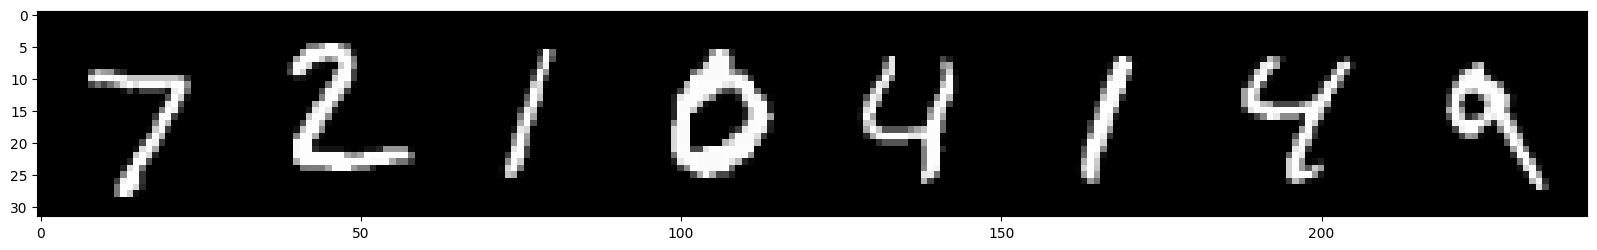

In [18]:

# Visualize the data!!!
plt.figure(figsize = (20,10))
out = make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))
